### ReFRACtor UQ Experiment Analysis

This notebook provides quick summary results from a simulation-based uncertainty quantification experiment, conducted using the [ReFRACtor OCO-2 setup](https://github.com/L2UQ/refractor_uq)

The simulation produces an ouptut file in HDF5 format with the aggregated retrieval results. The analysis consists of two key steps:

* Filtering: Diagnosing if retrievals successfully converged to a solution
    - `RetrievalResults/outcome_flag`: A value of 1 or 2 indicates the optimization reached a solution. A value of 3 indicates convergence was not reached in the allowed number of iterations. A missing value suggests the retrieval was not attempted or a low-level numerical failure occurred during the retrieval.
    - `SpectralParameters/reduced_chi_squared_o2`, `/SpectralParameters/reduced_chi_squared_strong_co2`, `/SpectralParameters/reduced_chi_squared_weak_co2`: These are goodness of fit metrics for each of the three bands. They are normalized, so values around 1 are consistent with successful convergence. If values are several times to an order of magnitude larger, the solution is probably suspect.
* Error assessment: Examining the distribution of retrieved quantities and errors on the subset of successful retrievals
    - `RetrievalResults/retrieved_xco2`, `RetrievalResults/retrieved_state_vector`: Retrieved quantities, which can be compared to their true counterparts: `/StateVector/true_xco2`, `/StateVector/true_state_vector`

In [1]:
import pandas
import numpy
import h5py
import matplotlib
from matplotlib import pyplot
from matplotlib import colors

Read in aggregated retrieval results

In [2]:
fnm = "lnd_nadir_201508_refractor_aggregate_retrieval.h5" 
f = h5py.File(fnm,'r')
oflg = f['/RetrievalResults/outcome_flag'][:]
chio2 = f['/SpectralParameters/reduced_chi_squared_o2'][:]
chist = f['/SpectralParameters/reduced_chi_squared_strong_co2'][:]
chiwk = f['/SpectralParameters/reduced_chi_squared_weak_co2'][:]
xco2hat = f['/RetrievalResults/retrieved_xco2'][:]
xco2tr = f['/StateVector/true_xco2'][:]
f.close()

sdsq = numpy.arange(oflg.shape[0])

In [3]:
print(oflg.shape)
print(oflg[0:10])
print(chio2[0:10])

(5000,)
[1 1 1 1 1 1 1 1 1 1]
[1.0101057  0.9381365  0.9747239  0.93134356 1.029195   0.9844205
 1.0532988  1.0839261  1.0241371  1.01317   ]


Create a data frame and tabulate outcome flag results. Convert XCO2 variables to parts per million

In [4]:
fltfrm = pandas.DataFrame({'SdgSeq':sdsq, 'OFlg':oflg, 'ChiO2':chio2, 'ChiWk':chiwk, 'ChiSt':chist, \
                           'XCO2True': 1.0e6 * xco2tr, 'XCO2Ret': 1.0e6 * xco2hat})
print(fltfrm[0:5])
print(fltfrm['OFlg'].value_counts())


   SdgSeq  OFlg     ChiO2     ChiWk     ChiSt    XCO2True     XCO2Ret
0       0     1  1.010106  1.003414  0.925099  394.118768  394.868439
1       1     1  0.938137  0.965213  1.009809  399.000305  398.498718
2       2     1  0.974724  0.967083  1.034666  391.822007  391.102448
3       3     1  0.931344  0.916969  1.024994  396.318412  395.815704
4       4     1  1.029195  0.958766  0.947733  397.358442  397.062103
 1     4923
 3       74
-99       3
Name: OFlg, dtype: int64


Subset on "good" retrievals

In [5]:
qlfrm = fltfrm.loc[ (fltfrm['OFlg'] == 1) & (fltfrm['ChiO2'] < 10.0) & (fltfrm['ChiWk'] < 10.0) & (fltfrm['ChiSt'] < 10.0)].copy()
print(qlfrm.shape)
qlfrm[100:105]


(4923, 7)


,SdgSeq,OFlg,ChiO2,ChiWk,ChiSt,XCO2True,XCO2Ret
100,100,1,1.043971,1.059636,0.929143,398.750600,398.776001
101,101,1,1.069356,1.045845,0.937689,398.240339,398.691467
102,102,1,0.998831,0.926735,1.018974,400.203088,400.755280
103,103,1,0.951606,0.970211,0.985089,397.811026,398.147400
104,104,1,1.036582,1.013258,0.973763,403.682287,403.830719


In [6]:
qlfrm[['ChiO2','ChiWk','ChiSt']].describe()

,ChiO2,ChiWk,ChiSt
count,4923.000000,4923.000000,4923.000000
mean,0.994679,1.001884,0.997432
std,0.065825,0.155275,0.157801
min,0.808143,0.826405,0.833043
25%,0.958178,0.954325,0.955275
50%,0.992669,0.991859,0.989253
75%,1.027719,1.030526,1.023400
max,3.576396,6.088896,6.797803


Summarize XCO2 error

In [7]:
qlfrm['XCO2Err'] = qlfrm['XCO2Ret'] - qlfrm['XCO2True']
qlfrm[['XCO2Err']].describe()

,XCO2Err
count,4923.000000
mean,-0.179800
std,0.416215
min,-5.454600
25%,-0.382246
50%,-0.152724
75%,0.073295
max,1.449261


Text(0.5, 1.0, 'Experiment Retrieval Error')

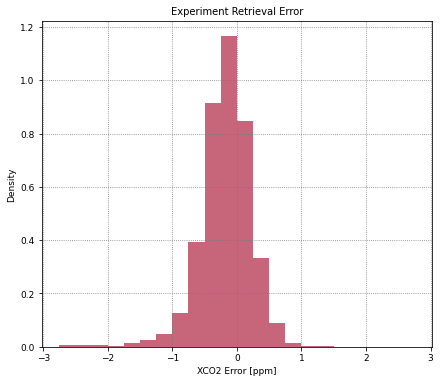

In [8]:
bnsqf = numpy.arange(-2.75,3.0,0.25)
clst = ["#C7657B","#998300","#009958","#0095B3","#A26EC4"]

%matplotlib inline
fig = pyplot.figure(figsize=(7,6))
p1 = pyplot.subplot(1,1,1)
n, bins, patches = pyplot.hist(qlfrm['XCO2Err'],bnsqf,density=True,facecolor=clst[0])
p1.set_xlabel('XCO2 Error [ppm]',size=9)
p1.set_ylabel('Density',size=9)
p1.xaxis.grid(color="#777777",linestyle='dotted')
p1.yaxis.grid(color="#777777",linestyle='dotted')
for lb in p1.xaxis.get_ticklabels():
    lb.set_fontsize(9)
for lb in p1.yaxis.get_ticklabels():
    lb.set_fontsize(9)
tstr = 'Experiment Retrieval Error' 
pyplot.title(tstr,size=10)

